# Parameters

In [10]:
source_folder = '/Users/andrewmendez1/Documents/ai-ml-challenge-2020/data/dummy_retrain_data'
destination_folder = '/Users/andrewmendez1/Documents/ai-ml-challenge-2020/data/dummy_retrain_data/model_result'


# Libraries

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

# NOTE Version of transformers, and torch has to align in order to reload models correctly

Currently have challenge training model on GPU and loading it on CPU macbook

In [13]:
# !pip install torch==1.4.0
# !pip install transformers

In [1]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, brier_score_loss

import seaborn as sns

In [84]:
import os
def get_dataset_filenames(dataset_directory):
    filenames = [ os.path.join(dataset_directory,i) for i in os.listdir(dataset_directory)]
    filenames = [i.split("/")[-1] for i in filenames if os.path.isfile(i)]
    return filenames[::-1]


# Preliminaries

In [73]:
# Model parameter
def load_dataset(source_folder,
                 device,
                 tokenizer,
                 MAX_SEQ_LEN=128,
                 BATCH_SIZE=16,
                 name_of_train_dataset='train.csv',
                 name_of_validation_dataset='valid.csv',
                 name_of_test_dataset='test.csv'):

    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

    # Fields

    label_field = Field(sequential=False,
                        use_vocab=False,
                        batch_first=True,
                        dtype=torch.float)
    
    text_field = Field(use_vocab=False,
                        tokenize=tokenizer.encode,
                        lower=False,
                        include_lengths=False,
                        batch_first=True,
                        fix_length=MAX_SEQ_LEN,
                        pad_token=PAD_INDEX,
                        unk_token=UNK_INDEX)
    # note, the fields must be in the same order as the input csv columns
    fields = [('clause_text', text_field),('label', label_field)]

    # TabularDataset

    train, valid, test = TabularDataset.splits(path=source_folder,
                                               train=name_of_train_dataset,
                                               validation=name_of_validation_dataset,
                                               test=name_of_test_dataset,
                                               format='CSV',
                                               fields=fields,
                                               skip_header=True)

    # Iterators

    train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.clause_text),
                                device=device, train=True, sort=True, sort_within_batch=True)
    valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.clause_text),
                                device=device, train=True, sort=True, sort_within_batch=True)
    test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
    return train_iter,valid_iter,test_iter

# train_iter,valid_iter,test_iter = load_dataset(source_folder,device,tokenizer,128,2,filenames[0],filenames[1],filenames[2])

# Models

In [6]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [7]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model,device):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path,device):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [78]:
# Training Function

def train(model,
          optimizer,
          device,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 1,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (text, label), _ in train_loader:
            label = label.type(torch.LongTensor)           
            label = label.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, label)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,label), _ in valid_loader:
                        label = label.type(torch.LongTensor)           
                        label = label.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, label)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [81]:
def plot_train_and_valid_losses(destination_folder,device):
    train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt',device)
    plt.plot(global_steps_list, train_loss_list, label='Train')
    plt.plot(global_steps_list, valid_loss_list, label='Valid')
    plt.xlabel('Global Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# plot_train_and_valid_losses(destination_folder,device)

# Evaluation

In [82]:
# Evaluation Function

def evaluate(model, test_loader,device):
    y_pred = []
    y_true = []
    output_probs = []
    model.eval()
    with torch.no_grad():
        for ( text, label), _ in test_loader:

                label = label.type(torch.LongTensor)           
                label = label.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, label)

                _, output = output
                output_probs.extend(F.softmax(output, dim=0).tolist())
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(label.tolist())
    
    # Brier score measures the mean squared difference between
    # (1) the predicted probability assigned to the possible outcomes for item i,
    # and (2) the actual outcome. Therefore, the lower the Brier score is for a set
    # of predictions, the better the predictions are calibrated.
    clf_score = brier_score_loss(y_true, [output_probs[i][y_pred[i]] for i in range(len(output_probs))], pos_label=0)
    print("Brier Score: %1.3f" % clf_score)

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Good', 'Bad'])
    ax.yaxis.set_ticklabels(['Good', 'Bad'])

In [85]:
def main(source_folder,destination_folder):
    '''
    Function to do end to end training
    '''



    # dataset_directory = '/Users/andrewmendez1/Documents/ai-ml-challenge-2020/data/dummy_retrain_data'
    filenames = get_dataset_filenames(source_folder)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_iter,valid_iter,test_iter = load_dataset(source_folder,device,tokenizer,128,2,filenames[0],filenames[1],filenames[2])


    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    train(model=model, optimizer=optimizer,device=device,file_path=destination_folder)

    plot_train_and_valid_losses(destination_folder,device)

    best_model = BERT().to(device)
    load_checkpoint(destination_folder + '/model.pt', best_model,device)
    evaluate(best_model, test_iter,device)
    return best_model
source_folder = '/Users/andrewmendez1/Documents/ai-ml-challenge-2020/data/dummy_retrain_data'
destination_folder = '/Users/andrewmendez1/Documents/ai-ml-challenge-2020/data/dummy_retrain_data/model_result'
main(source_folder,destination_folder)

cpu
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

KeyboardInterrupt: 

# Text Classification Interpretability

In [86]:
# !pip install captum

In [5]:
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [8]:
# load_checkpoint('/content/drive/My Drive/gsa_eula_2020_challenge/Model/model.pt', model)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def load_model(path,device):
    model = BERT().to(device)
    load_checkpoint(path, model,device)
    model.to(device)
    model.eval()
    model.zero_grad()
    return model

model = load_model('/Users/andrewmendez1/Documents/ai-ml-challenge-2020/data/Finetune BERT oversampling 8_16_2020/Model_1_4_0/model.pt',device)

# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
def predict(inputs):
    #print('model(inputs): ', model(inputs))
    return model.encoder(inputs)[0]

In [10]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence
# print(cls_token_id, ref_token_id,sep_token_id)

In [11]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
 
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [12]:
def custom_forward(inputs):
    preds = predict(inputs)
    return torch.softmax(preds, dim = 1)[:, 0] # for negative attribution, torch.softmax(preds, dim = 1)[:, 1] <- for positive attribution

In [13]:
lig = LayerIntegratedGradients(custom_forward, model.encoder.bert.embeddings)

In [14]:
bad_text = """
company warrants that the software for a period of sixty days from the date of your perform substantially in accordance with software written materials accompanying except as just parties acknowledge that the software is provided and may not be functional on every machine or in every except as set forth company disclaims all warranties relating to the express or but not limited any warranties against infringement of third party merchantability and fitness for a particular"""

In [15]:
# text = "the exclusion of implied warranties is not permitted by some the above exclusion may not apply to"# label 0
text= "this license shall be effective until company in its sole and absolute at any time and for any or no disable the or suspend or terminate this license and the rights afforded to you with or without prior notice or other action by upon the termination of this you shall cease all use of the app and uninstall the company will not be liable to you or any third party for or damages of any sort as a result of terminating this license in accordance with its and termination of this license will be without prejudice to any other right or remedy company may now or in the these obligations survive termination of this"
label=1


In [28]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)
# print("input_ids: {}".format(input_ids))# actual text
# print("ref_input_ids: {}".format(ref_input_ids))# baseline text
# indices = input_ids[0].detach().tolist()
# all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [17]:
#saved_act = None
def save_act(module, inp, out):
  #global saved_act
  #saved_act = out
  return saved_act

hook = model.encoder.bert.embeddings.register_forward_hook(save_act)

In [18]:
hook.remove()

In [19]:
# Check predict output
# custom_forward(torch.cat([input_ids]))
# input_ids.shape

torch.Size([1, 120])

In [20]:
# pred = predict(input_ids)
# torch.softmax(pred, dim = 1)

In [21]:
# custom_forward(input_ids)

In [22]:
# input_ids

In [24]:
# from time import time
# t0 = time()
# attributions_main, delta_main = lig.attribute(inputs=input_ids,baselines=ref_input_ids,return_convergence_delta=True,n_steps=30)
# print(time()-t0)
# print((time()-t0)/60)

33.338720083236694
0.5556488315264384


In [120]:
attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    # n_steps=7000,
                                    # internal_batch_size=5,
                                    return_convergence_delta=True,
                                    n_steps=30)

In [ ]:
# torch.sum(attributions_main), torch.sum(attributions)

In [ ]:
# delta, delta_main

In [113]:
score = predict(input_ids)

print('Sentence: ', text)
print('Sentiment: ' + str(torch.argmax(score[0]).cpu().numpy()) + \
      ', Probability Not acceptable: ' + str(torch.softmax(score, dim = 1)[0][1].cpu().detach().numpy()))

Sentence:  this license shall be effective until company in its sole and absolute at any time and for any or no disable the or suspend or terminate this license and the rights afforded to you with or without prior notice or other action by upon the termination of this you shall cease all use of the app and uninstall the company will not be liable to you or any third party for or damages of any sort as a result of terminating this license in accordance with its and termination of this license will be without prejudice to any other right or remedy company may now or in the these obligations survive termination of this
Sentiment: 1, Probability Not acceptable: 0.97422045


In [114]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [115]:
attributions_sum = summarize_attributions(attributions)

In [129]:
# attributions_sum.shape

torch.Size([120])

In [139]:
def get_topk_attributed_tokens(attrs,all_tokens, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

In [25]:
# input_ids[0].shape


In [26]:
all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().tolist())
print(all_tokens)
top_tokens, values, indicies = get_topk_attributed_tokens(attributions_sum,all_tokens,k=7)

In [190]:
# ['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

In [27]:
# attributions_sum.sum()

In [153]:
[(a,b.item(),c.item()) for a,b,c in zip(top_tokens, values, indicies) ]

[('until', 0.16741116344928741, 6),
 ('effective', 0.11294282227754593, 5),
 ('survive', 0.021591752767562866, 115),
 ('in', 0.02052856981754303, 111),
 ('termination', 0.019045813009142876, 116),
 ('absolute', 0.01318704430013895, 12),
 ('or', 0.009534455835819244, 105)]

Text(0.5, 1.0, 'Top 5 Tokens that attributed to prediction')

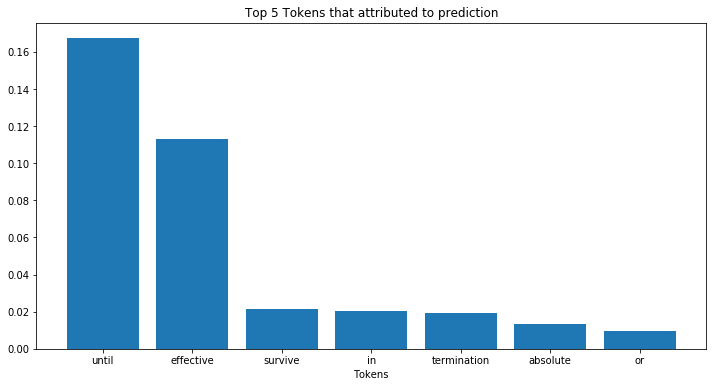

In [165]:
import numpy as np
plt.figure(figsize=(12,6))
x_pos = np.arange(len(values))
plt.bar(x_pos,values.detach().numpy(), align='center')
plt.xticks(x_pos, top_tokens, wrap=True)
plt.xlabel("Tokens")
plt.title("Top 5 Tokens that attributed to prediction")

In [116]:
# storing couple samples in an array for visualization purposes
score_vis = viz.VisualizationDataRecord(attributions_sum,
                                        torch.softmax(score, dim = 1)[0][0],
                                        torch.argmax(torch.softmax(score, dim = 1)[0]),
                                        label,
                                        text,
                                        attributions_sum.sum(),       
                                        all_tokens,
                                        delta)

In [117]:
score_vis

In [118]:
print('\033[1m', 'Visualization For Score', '\033[0m')
viz.visualize_text([score_vis])

 Visualization For Score 


In [ ]:
 torch.argmax(torch.softmax(score, dim = 1)[0])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

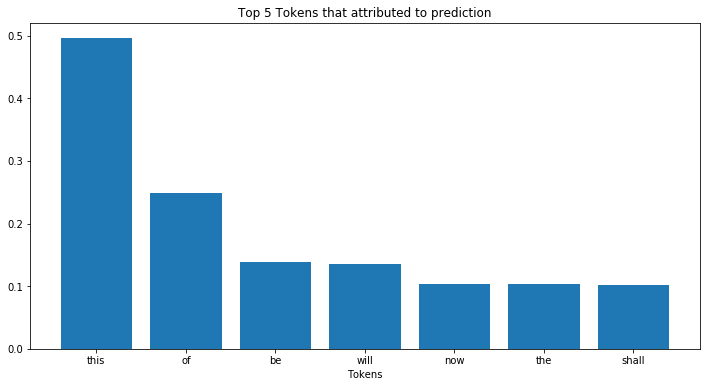

In [1]:
# import matplotlib.pyplot as plt
# import pandas as pd
import torch

# Preliminaries

# from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

# import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, brier_score_loss

import seaborn as sns

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from time import time
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea
def load_model(path,device):
    model = BERT().to(device)
    load_checkpoint(path, model,device)
    model.to(device)
    model.eval()
    model.zero_grad()
    return model

def construct_input_ref_pair(text, tokenizer,device, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
 
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids,device, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids,device):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)



def save_act(module, inp, out):
  #global saved_act
  #saved_act = out
  return saved_act

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def get_topk_attributed_tokens(attrs,all_tokens, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

def load_checkpoint(load_path, model,device):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)

def main(text,label):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = load_model('/Users/andrewmendez1/Documents/ai-ml-challenge-2020/data/Finetune BERT oversampling 8_16_2020/Model_1_4_0/model.pt',device)
    def predict(inputs):
        #print('model(inputs): ', model(inputs))
        return model.encoder(inputs)[0]
    def custom_forward(inputs):
        preds = predict(inputs)
        return torch.softmax(preds, dim = 1)[:, 0] 
    # load tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
    sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
    cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence
    hook = model.encoder.bert.embeddings.register_forward_hook(save_act)
    hook.remove()


    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text,tokenizer,device, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, device,sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids,device)
    attention_mask = construct_attention_mask(input_ids)

    # text = "the exclusion of implied warranties is not permitted by some the above exclusion may not apply to"# label 0

    lig = LayerIntegratedGradients(custom_forward, model.encoder.bert.embeddings)
    # attributions_main, delta_main = lig.attribute(inputs=input_ids,baselines=ref_input_ids,return_convergence_delta=True,n_steps=30)
    t0 = time()
    attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    # n_steps=7000,
                                    # internal_batch_size=5,
                                    return_convergence_delta=True,
                                    n_steps=50)
    print("Time: {} seconds".format(time()-t0))
    print("Time in {} minutes".format( (time()-t0)/60 ))
    attributions_sum = summarize_attributions(attributions)

    all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().tolist())
    top_tokens, values, indicies = get_topk_attributed_tokens(attributions_sum,all_tokens,k=7)
    score = predict(input_ids)
    score_vis = viz.VisualizationDataRecord(attributions_sum,
                                            torch.softmax(score, dim = 1)[0][0],
                                            torch.argmax(torch.softmax(score, dim = 1)[0]),
                                            label,
                                            text,
                                            attributions_sum.sum(),       
                                            all_tokens,
                                            delta)
    print('\033[1m', 'Visualization For Score', '\033[0m')
    viz.visualize_text([score_vis])


    import numpy as np
    plt.figure(figsize=(12,6))
    x_pos = np.arange(len(values))
    plt.bar(x_pos,values.detach().numpy(), align='center')
    plt.xticks(x_pos, top_tokens, wrap=True)
    plt.xlabel("Tokens")
    plt.title("Top 5 Tokens that attributed to prediction")

text= "this license shall be effective until company in its sole and absolute at any time and for any or no disable the or suspend or terminate this license and the rights afforded to you with or without prior notice or other action by upon the termination of this you shall cease all use of the app and uninstall the company will not be liable to you or any third party for or damages of any sort as a result of terminating this license in accordance with its and termination of this license will be without prejudice to any other right or remedy company may now or in the these obligations survive termination of this"
# label=1
label = "?"
main(text,label)
